In [1]:
library('readr')
library('magrittr')
library('dplyr')
library('tidyr')
library('ggplot2')


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘tidyr’

The following object is masked from ‘package:magrittr’:

    extract



In [2]:
org_options <- options()
tilt_labels <- theme(axis.text.x=element_text(angle=75, hjust=1))

In [3]:
donors <- c('Donor 36', 'Donor 38', 'Donor 39')

count_data <-
    read_tsv(
        'count-data.tsv',
        col_types=cols(
            `Donor`=col_factor(levels=donors),
            `Depletion`=col_factor(levels=c('No-depletion', 'CD45RO-depleted', 'CD45RA-depleted')),
            `Day post-activation`=col_factor(levels=c('Day 2', 'Day 5')),
            `Cell state`=col_factor(levels=c('Unstimulated', 'Activated')),
            .default=col_double()
        )
    ) %>% mutate(`Count`=((`Count 1` + `Count 2`) / 2) * 1e5)

count_data %>% head

Donor,Depletion,Day post-activation,Cell state,Count 1,Count 2,Count
Donor 38,No-depletion,Day 2,Activated,1.82,1.33,157500
Donor 38,No-depletion,Day 2,Unstimulated,2.43,2.45,244000
Donor 38,CD45RA-depleted,Day 2,Activated,1.16,1.51,133500
Donor 38,CD45RA-depleted,Day 2,Unstimulated,2.19,2.89,254000
Donor 38,CD45RO-depleted,Day 2,Activated,1.08,1.27,117500
Donor 38,CD45RO-depleted,Day 2,Unstimulated,2.52,2.13,232500


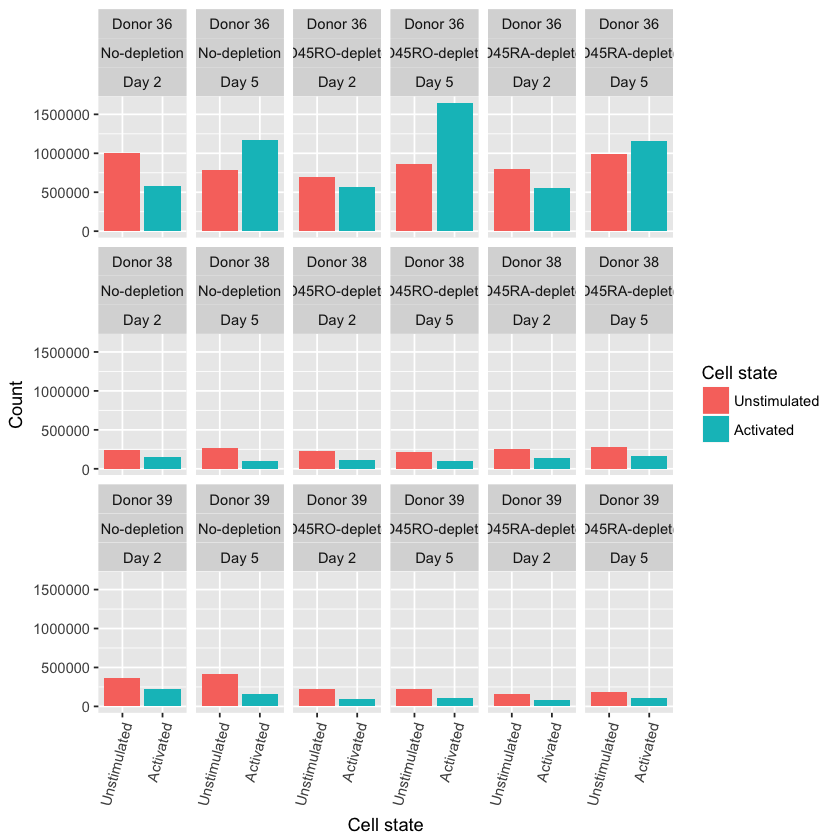

In [4]:
options(repr.plot.width=7, repr.plot.height=7)

count_data %>%
    ggplot(aes(x=`Cell state`, y=`Count`, fill=`Cell state`)) +
    geom_col(position="dodge") +
    facet_wrap(~`Donor`+`Depletion`+`Day post-activation`, ncol=6) +
    tilt_labels

In [5]:
flow_data <-
    read_tsv(
        'flow-data.tsv',
        col_types=cols(
            `Sample:`=col_character(),
            `Donor`=col_factor(levels=c('Donor 36', 'Donor 38', 'Donor 39')),
            `Depletion`=col_factor(levels=c('No-depletion', 'CD45RO-depleted', 'CD45RA-depleted')),
            `Day post-activation`=col_factor(levels=c('Day 2', 'Day 5')),
            `Cell state`=col_factor(levels=c('Unstimulated', 'Activated')),
            .default=col_double()
        )
    ) %>%
    gather(
        key="Population",
        value="Frequency",
        factor_key=TRUE,
        `Naive`:`EMRA`
    )

flow_data %>% head

Sample:,Donor,Depletion,Day post-activation,Cell state,Population,Frequency
D38-ND-ACT.fcs,Donor 38,No-depletion,Day 2,Activated,Naive,30.40
D38-ND-US.fcs,Donor 38,No-depletion,Day 2,Unstimulated,Naive,51.40
D38-RA-ACT.fcs,Donor 38,CD45RA-depleted,Day 2,Activated,Naive,0.78
D38-RA-US.fcs,Donor 38,CD45RA-depleted,Day 2,Unstimulated,Naive,1.45
D38-RO-ACT.fcs,Donor 38,CD45RO-depleted,Day 2,Activated,Naive,24.30
D38-RO-US.fcs,Donor 38,CD45RO-depleted,Day 2,Unstimulated,Naive,84.80


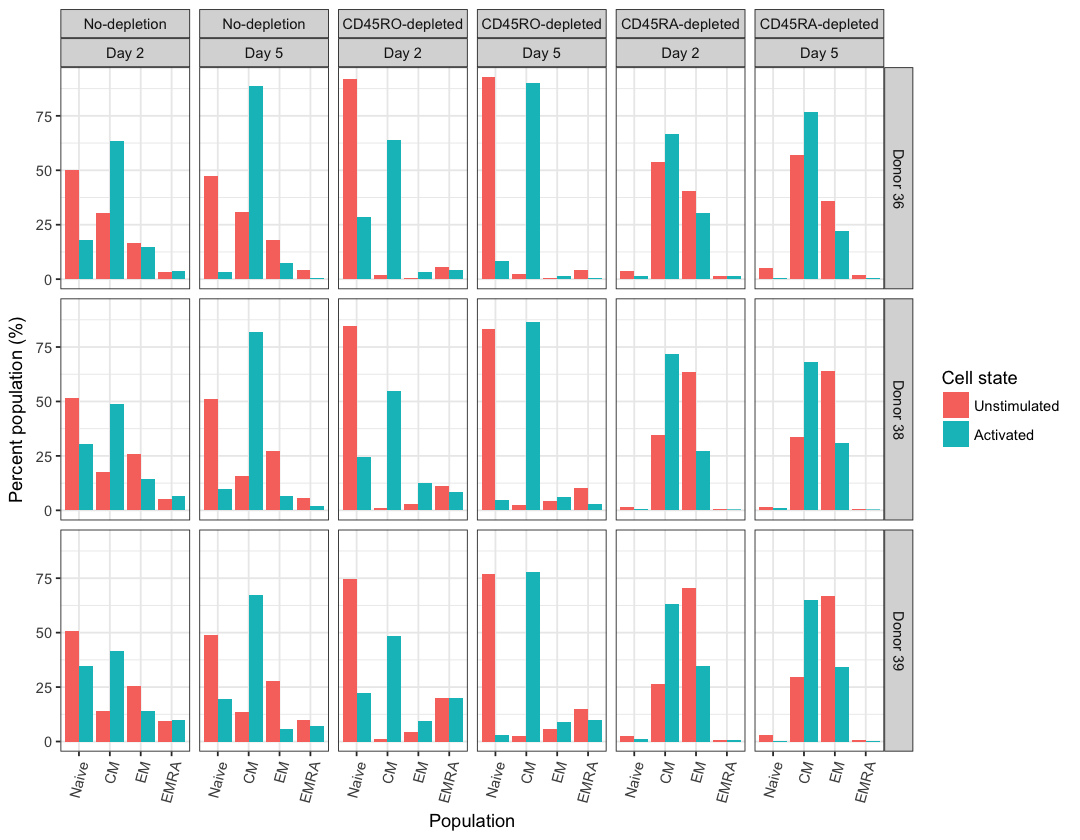

In [14]:
options(repr.plot.width=9, repr.plot.height=7)

flow_data %>%
    ggplot(aes(x=`Population`, y=`Frequency`, fill=`Cell state`)) +
    geom_col(position="dodge") +
    facet_wrap(~`Donor`+`Depletion`+`Day post-activation`, ncol=6) +
    #facet_grid(`Donor`~`Depletion`+`Day post-activation`) +
    theme_bw() +
    ylab('Percent population (%)') +
    tilt_labels

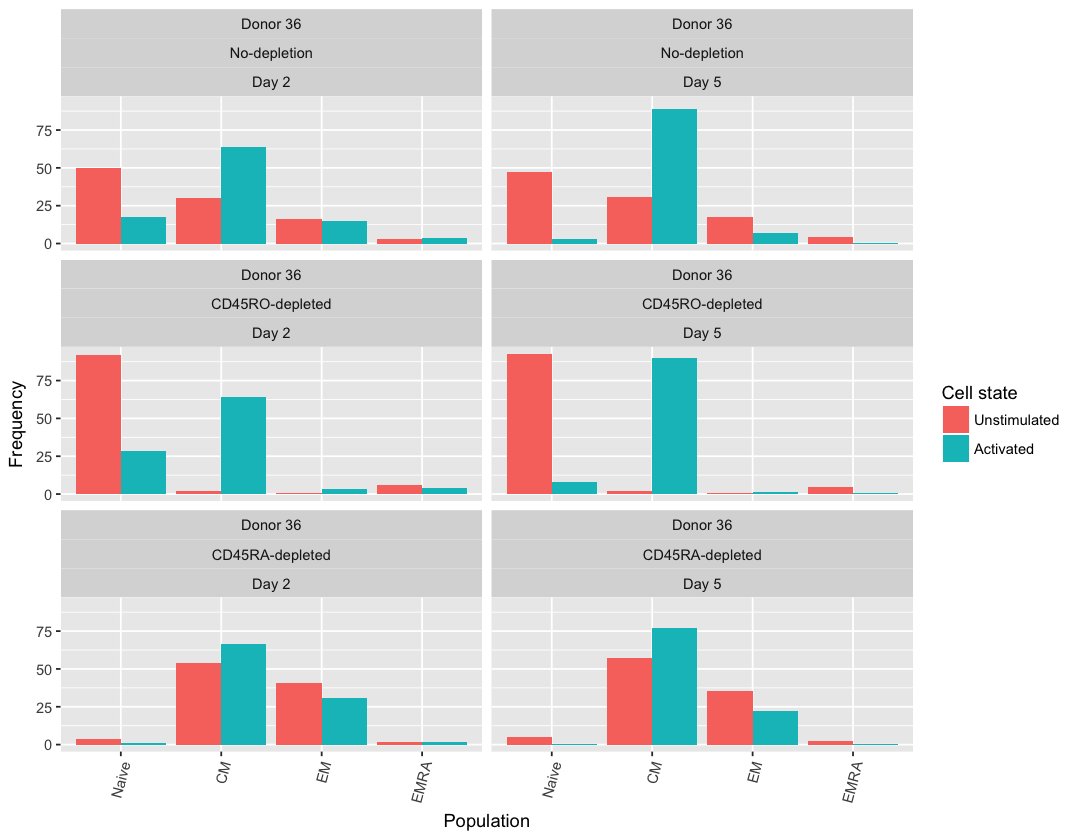

In [7]:
flow_data %>%
    filter(`Donor` == 'Donor 36') %>%
    ggplot(aes(x=`Population`, y=`Frequency`, fill=`Cell state`)) +
    geom_col(position="dodge") +
    facet_wrap(~`Donor`+`Depletion`+`Day post-activation`, ncol=2) +
    tilt_labels

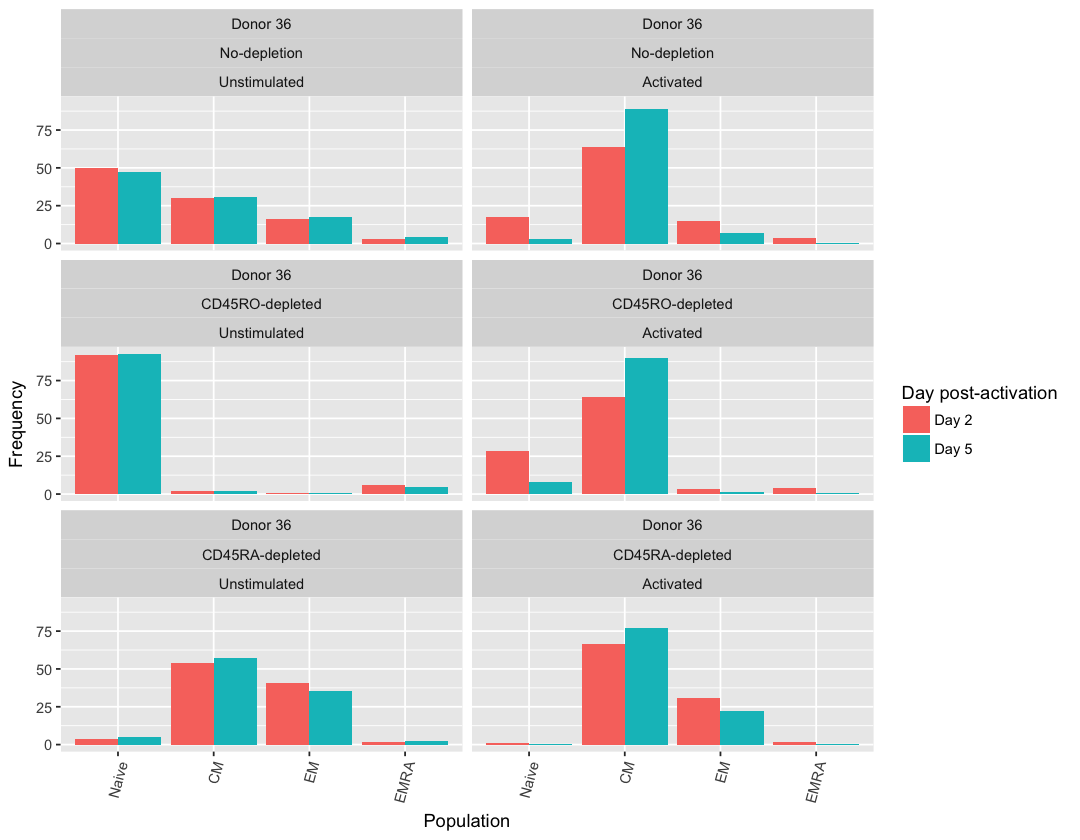

In [8]:
flow_data %>%
    filter(`Donor` == 'Donor 36') %>%
    ggplot(aes(x=`Population`, y=`Frequency`, fill=`Day post-activation`)) +
    geom_col(position="dodge") +
    facet_wrap(~`Donor`+`Depletion`+`Cell state`, ncol=2) +
    tilt_labels

In [9]:
merged_data <-
    left_join(
        count_data,
        flow_data,
        by=c(
            "Donor",
            "Depletion",
            "Day post-activation",
            "Cell state"
        )
    ) %>%
    mutate(`Population_count`=`Count` * (`Frequency` / 100.0)) %>%
    select(-`Count 1`, -`Count 2`, -`Count`, -`Sample:`)

merged_data %>% head

Donor,Depletion,Day post-activation,Cell state,Population,Frequency,Population_count
Donor 38,No-depletion,Day 2,Activated,Naive,30.40,47880
Donor 38,No-depletion,Day 2,Activated,CM,48.80,76860
Donor 38,No-depletion,Day 2,Activated,EM,14.40,22680
Donor 38,No-depletion,Day 2,Activated,EMRA,6.36,10017
Donor 38,No-depletion,Day 2,Unstimulated,Naive,51.40,125416
Donor 38,No-depletion,Day 2,Unstimulated,CM,17.50,42700


In [10]:
write_csv(x=merged_data, "counts_percent.csv")

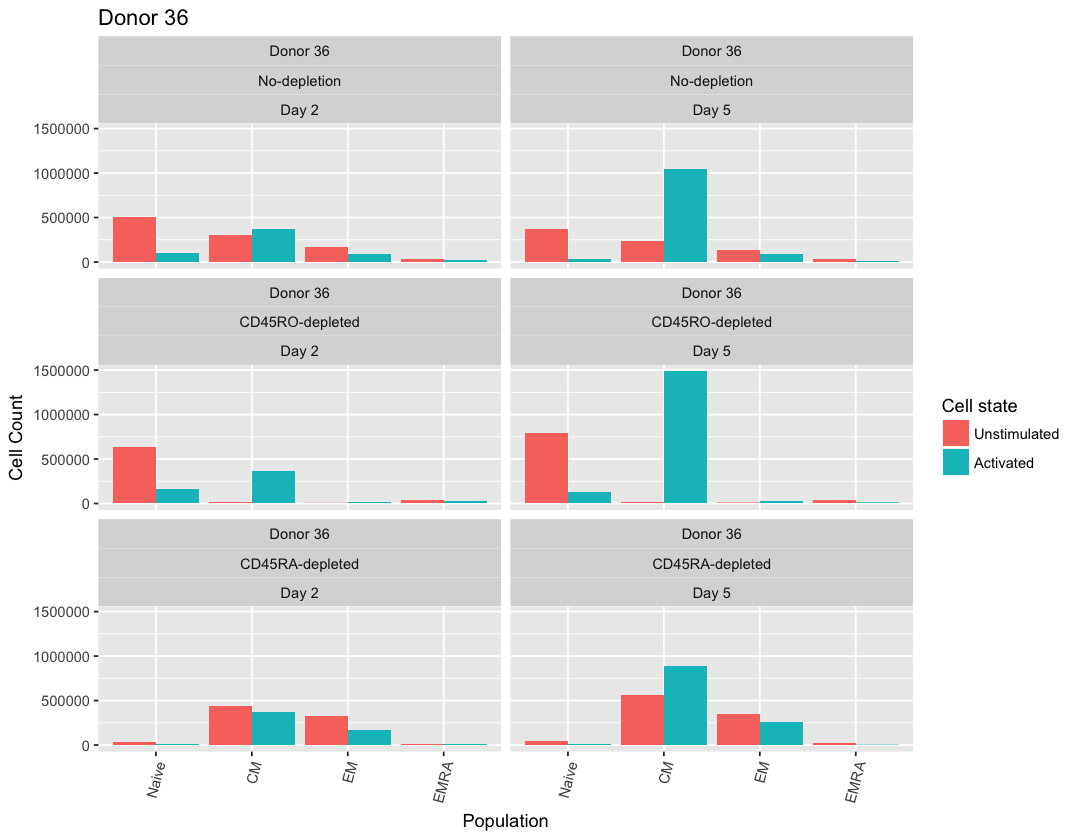

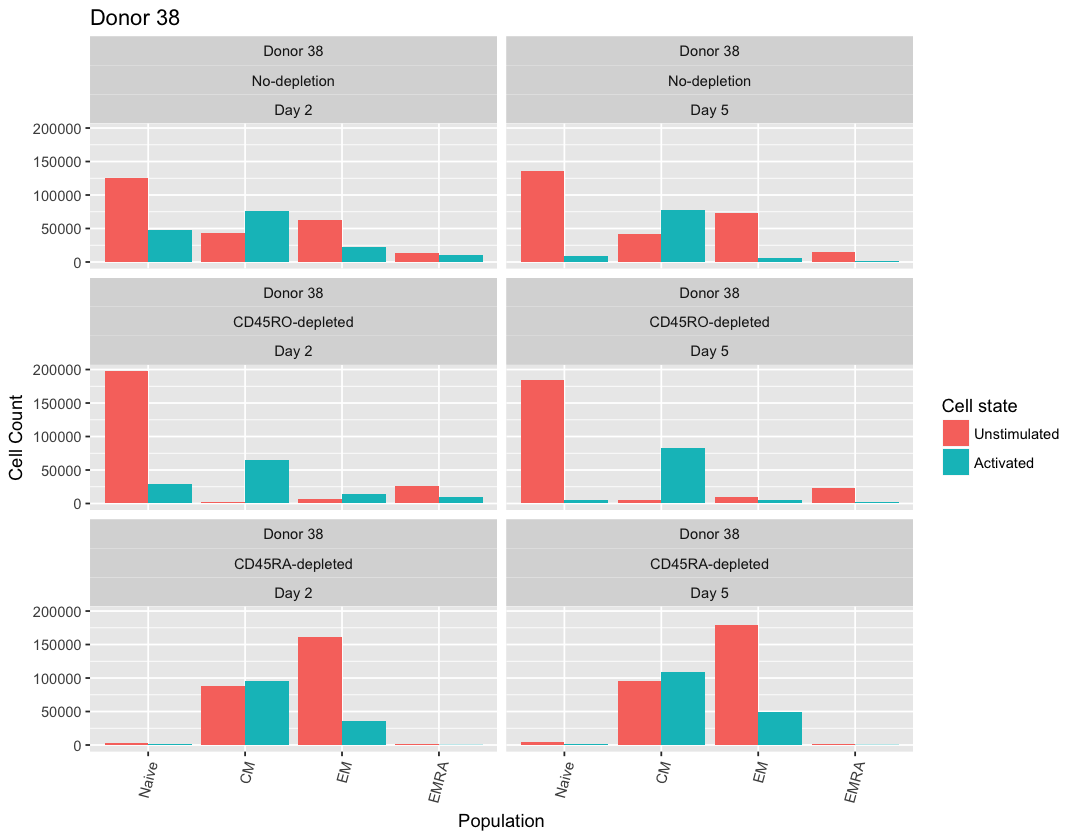

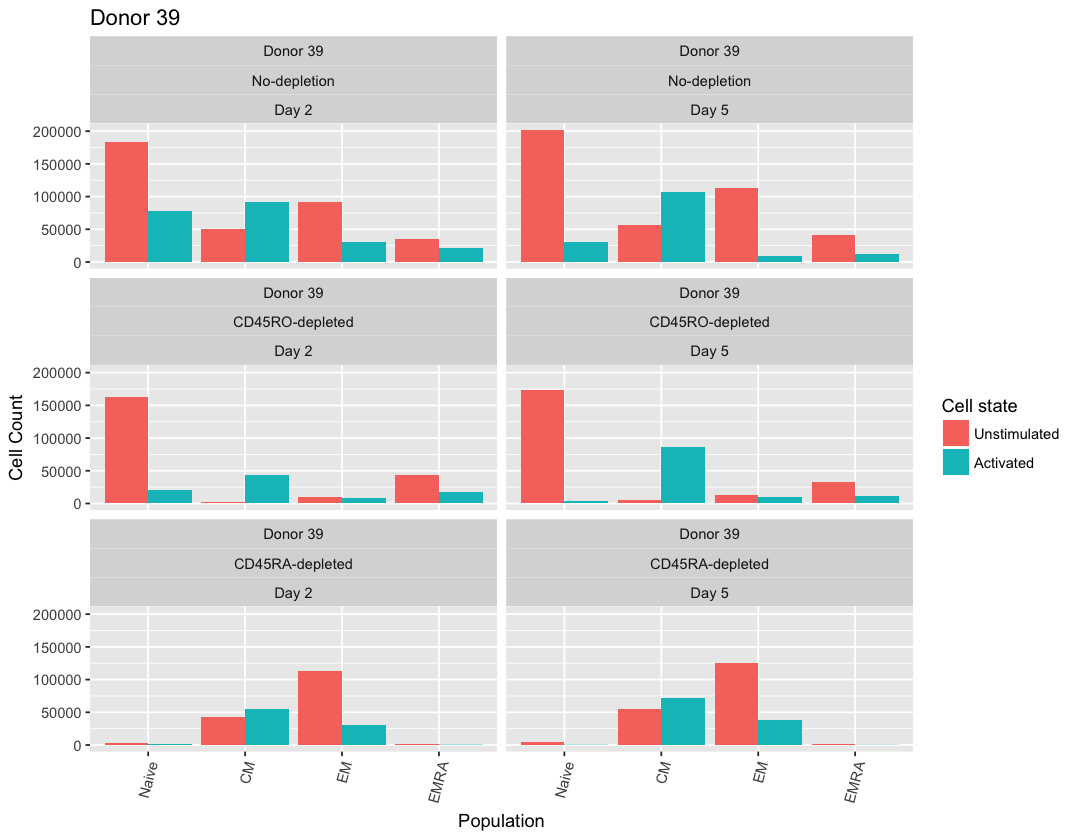

In [11]:
for(donor in donors) {
    donor_plot <- 
        merged_data %>%
        filter(`Donor` == donor) %>%
        ggplot(aes(x=`Population`, y=`Population_count`, fill=`Cell state`)) +
        geom_col(position="dodge") +
        facet_wrap(~`Donor`+`Depletion`+`Day post-activation`, ncol=2) +
        ggtitle(donor) +
        ylab('Cell Count') +
        tilt_labels
    print(donor_plot)
}

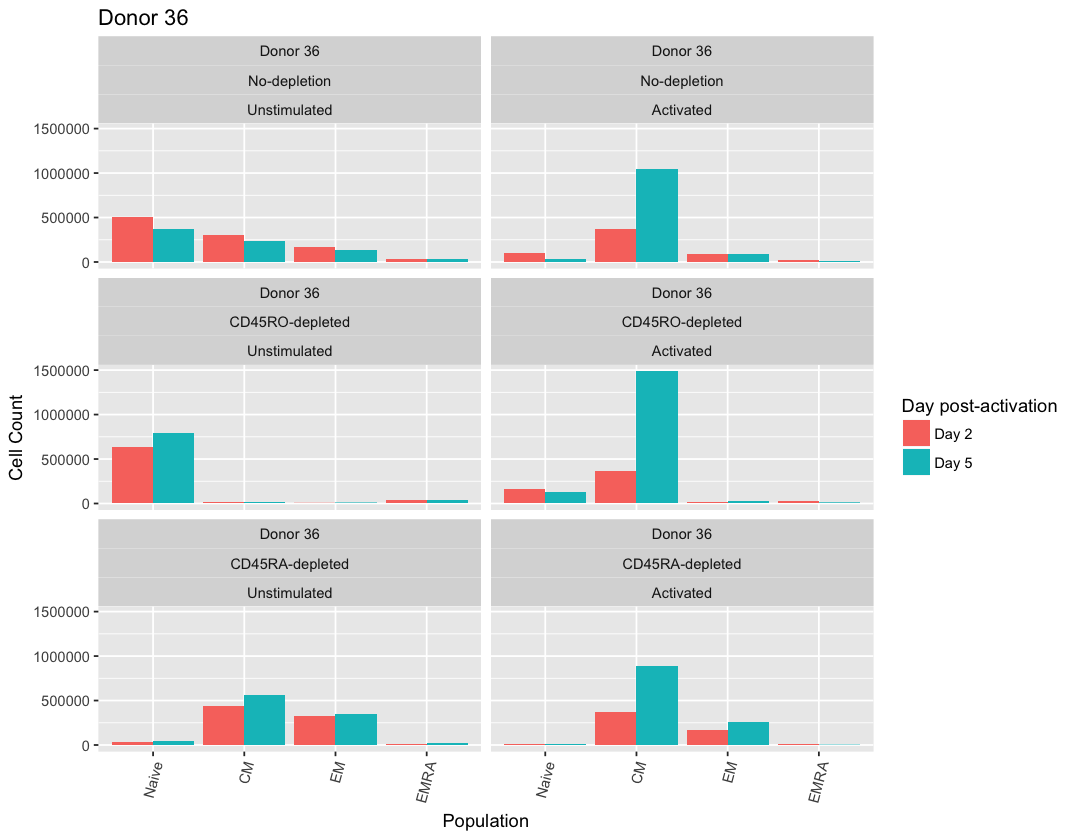

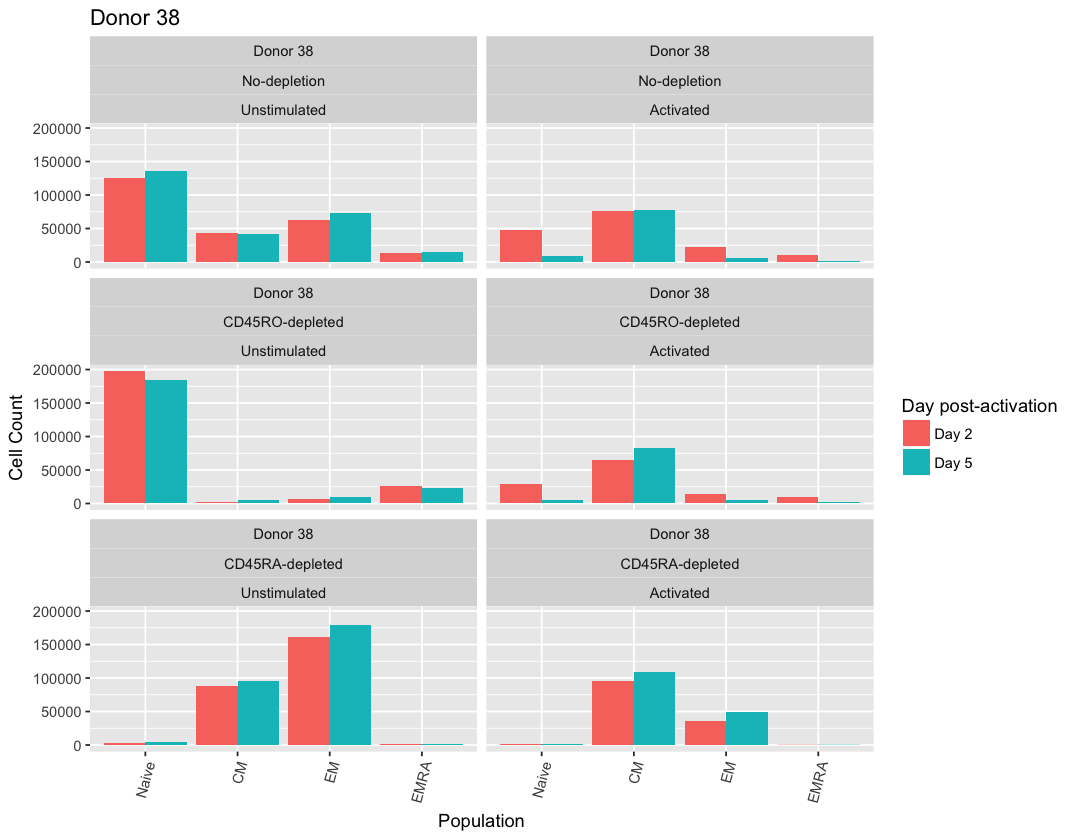

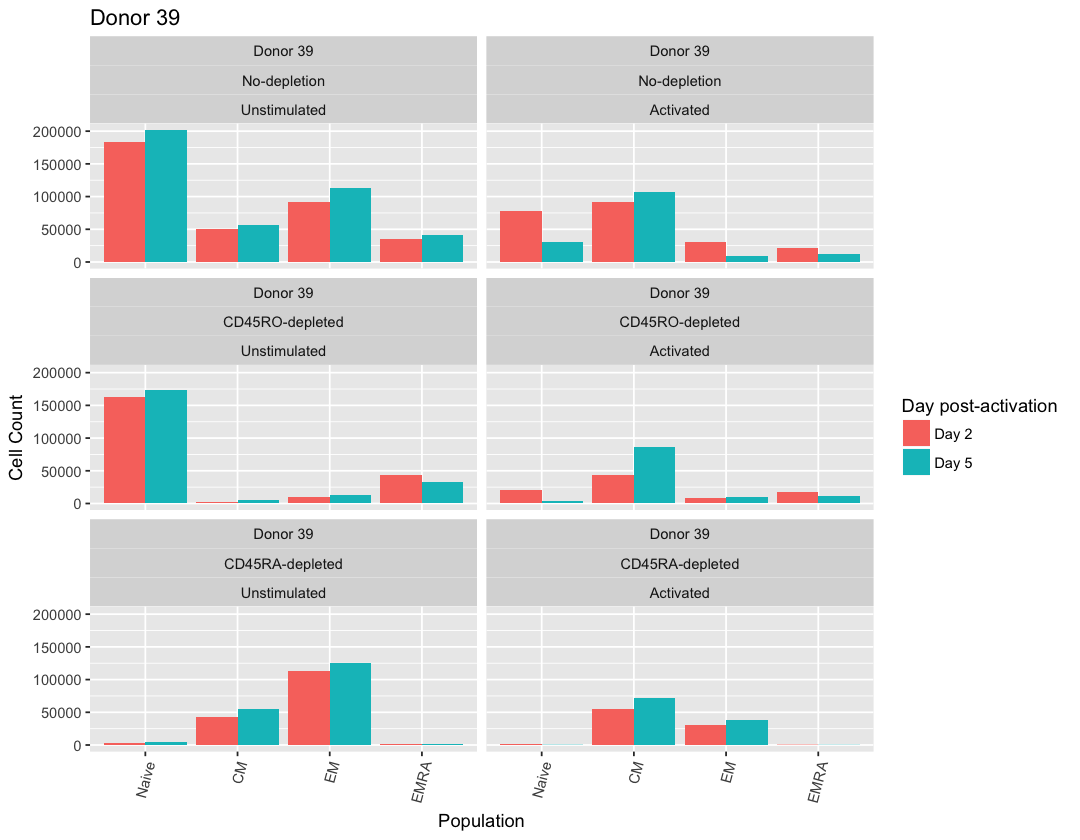

In [12]:
for(donor in donors) {
    donor_plot <- 
        merged_data %>%
        filter(`Donor` == donor) %>%
        ggplot(aes(x=`Population`, y=`Population_count`, fill=`Day post-activation`)) +
        geom_col(position="dodge") +
        facet_wrap(~`Donor`+`Depletion`+`Cell state`, ncol=2) +
        ggtitle(donor) +
        ylab('Cell Count') +
        tilt_labels
    print(donor_plot)
}